# XGBoost

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

from skopt import forest_minimize  # Random forest hyperparameter optimization
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.callbacks import DeltaYStopper

# Project level modules
import modules.preprocessing_functions as ppf

In [43]:
# Random State
rs = 99

## Load Data

In [3]:
google_drive_path = ('~/Google Drive/My Drive/Lighthouse Labs/'
                     + 'Mid-term Project/Data-Jan/')

In [146]:
def load_and_process(csv_path: 'str'):
    """
    Load the csv, process NAN values in the target variable, and
    drop irrelevant rows
    
    Parameters
    ----------
    csv_path : string
    
    Returns
    -------
    df : Pandas Dataframe
    """
    
    # Load csv and parse the first column as dates
    df = pd.read_csv(csv_path, parse_dates=[0])
    
    # Set NAN values in the target feature to 0
    df = ppf.process_nan_values(
        df=df,
        features_to_zero=['arr_delay']
    )
    
    # Drop flight rows that were cancelled or diverted
    df = df[
        (df['cancelled'] == 0) &
        (df['diverted'] == 0)
    ]
    
    # Drop flights with delay >3std
    df = df[
        (df['arr_delay'] < (df['arr_delay'].mean()
                            + 3 * df['arr_delay'].std()))
    ]
    
    # Drop flights with delay <-120min
    df = df[
        (df['arr_delay'] > -120)
    ]
    
    # Add stratifier
    df['is_delayed'] = 0
    df.loc[(df['arr_delay'] > 0), 'is_delayed'] = 1
    
    return df

In [7]:
file_name = 'sample'
path = f'../data/{file_name}.csv'

In [147]:
data = load_and_process(csv_path=path)

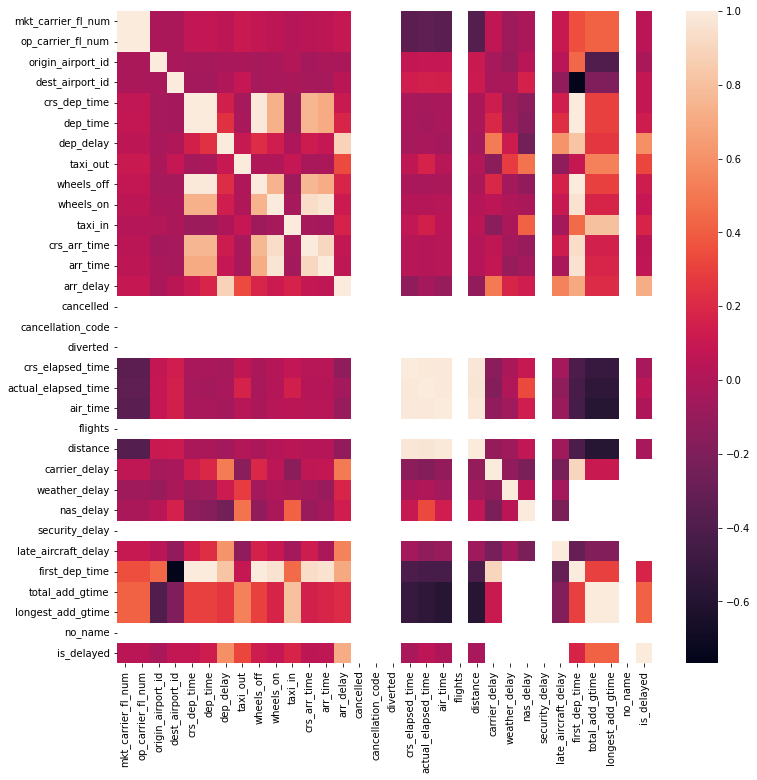

In [63]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data.corr())
plt.show()

## Data Split

In [161]:
# Predictor features set
X = ppf.flight_test_features(data, purged=True)
# Drop origin and destination code
X.drop(['origin', 'dest'], axis=1, inplace=True)
# Target variable
y = data[['arr_delay', 'is_delayed']]

In [149]:
X.shape, y.shape

((9806, 8), (9806,))

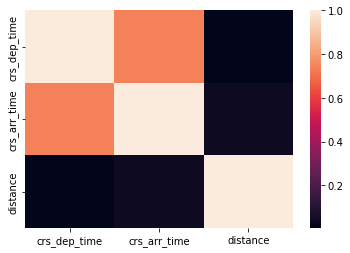

In [111]:
fig, ax = plt.subplots()
ax = sns.heatmap(X.corr())
plt.show()

## Preprocessing

In [ ]:
# NA replacement
# Split X into categorical and numeric features
# For numeric
# Scale and transform
# For categorical
# One hot encode/dummy

### Categorical

In [162]:
X_numerical, X_categorical = ppf.numerical_categorical_split(df=X)

#### One hot encoding
Doing One hot encoding before the train test split is based on the Machine Learning Mastery tutorial [Data Preparation for Gradient Boosting with XGBoost in Python](https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/)

In [163]:
# One hot encoding
X_cat_one_hot = pd.get_dummies(
    X_categorical,
    prefix=X_categorical.columns[1:],
    # will fl_date be encoded if there was more than one date?
    drop_first=True
)

# Reconstitue original data table with one hot encoded features
X_one_hot = pd.concat([X_cat_one_hot, X_numerical], axis=1)

### Train Test Split

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X_one_hot, y['arr_delay'],
    train_size=0.8,
    test_size=0.2,
    stratify=y['is_delayed'],
    random_state=rs
)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Numerical

In [165]:
# Separate numeric and categorical features

numeric_features = X_numerical.columns.to_list() + ['fl_date']

X_train_num = X_train[numeric_features].copy()
X_train_cat = X_train.drop(numeric_features, axis=1)  # One hot encoded

X_test_num = X_test[numeric_features].copy()
X_test_cat = X_test.drop(numeric_features, axis=1)  # One hot encoded

# Convert fligth date to an integer
X_train_num.loc[:, 'fl_date'] = X_train_num['fl_date'].view(int) / 1e11
X_test_num.loc[:, 'fl_date'] = X_test_num['fl_date'].view(int) / 1e11

# Scale numeric features
scaler = MinMaxScaler()
X_train_num_scaled = pd.DataFrame(
    scaler.fit_transform(X=X_train_num),
    columns=X_train_num.columns
)
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X=X_test_num),
    columns=X_test_num.columns
    )

# Reconstitue train and test datasets
X_train = pd.concat([X_train_cat, X_train_num_scaled], axis=1)
X_test = pd.concat([X_test_cat, X_test_num_scaled], axis=1)

In [126]:
# Dmatrix : XGBoost optimized data structure
DMat_train = xgb.DMatrix(
    data=X_train,
    label=y_train
)
DMat_test = xgb.DMatrix(
    data=X_test,
    label=y_test
)

## Training

### Default

[XGBoost.train](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=xgboost%20train#xgboost.train)

>```Python
xgb.train(params, dtrain, num_boost_round=10,  
evals=(), obj=None, feval=None,  
maximize=None, early_stopping_rounds=None, evals_result=None,  
verbose_eval=True, xgb_model=None, callbacks=None)```

[XGBRegressor().fit](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=fit#xgboost.XGBRegressor.fit)

>```Python
xgb.XGBRegressor().fit(X, y, *,  
sample_weight=None, base_margin=None, eval_set=None,  
eval_metric=None, early_stopping_rounds=None, verbose=True,  
xgb_model=None, sample_weight_eval_set=None, base_margin_eval_set=None,  
feature_weights=None, callbacks=None)```


In [166]:
xg_reg_default = xgb.XGBRegressor(random_state=rs)
xg_reg_default.fit(X=X_train, y=y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=99,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [167]:
y_pred_default = xg_reg_default.predict(X_test)

In [168]:
# Root mean squared error
rmse = mean_squared_error(
    y_true=y_test,
    y_pred=y_pred_default,
    squared=False
)
print(f'RMSE: {rmse}')

RMSE: 26.640815906167518


In [157]:
pd.DataFrame(y_pred_default).describe()

,0
count,1962.000000
mean,-1.596336
std,9.507218
min,-24.362974
25%,-7.145019
50%,-3.178716
75%,1.435651
max,71.468399


## Grid Searching

In [ ]:
params = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [3, 6, 10],
    'learning_rate' : [0.01, 0.1, 0.3, 0.5],
    'objective' : 'reg:squarederror',
    'gamma' : [0, 0.1, 0.2]
    'reg_lambda' : ,
    'random_state'=rs
}

In [ ]:
GS = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=params,
    n_jobs=-1
)

## Forest Minimize

In [158]:
reg = xgb.XGBRegressor(random_state=rs)

space = space = [
    Real(10**-3, 10**0, prior='log-uniform', name='learning_rate'),
    Integer(10, 100, name='n_estimators'),
    Integer(1, 10, name='max_depth'),
    Real(1, 6., name='min_child_weight'),
    Real(0, 0.5, name='gamma'),
    Real(0.5, 1., name='subsample'),
    Real(0.5, 1., name='colsample_bytree'),
    Real(0, 5., name='reg_lambda'),  #  L2 regularization
    Real(0, 5., name='reg_alpha'),  #  L1 regularization
]

In [159]:
@use_named_args(space)
def tune_xgbr(**params):
    # Implementation from Pedro Couto (https://www.kaggle.com/general/17120)
    """
    Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters
    ----------
    Tuples with information about the range that the optimizer should
    use for that parameter, as well as the behaviour that it should
    follow in that range.

    Returns
    -------
    float : the metric that should be minimized.
        If the objective is maximization, then the negative of the
        desired metric must be returned. e.g. AUC for classifiers
    """
    
    reg.set_params(**params)

    print(params)

    #Cross-Validation in order to avoid overfitting
    rmse = -cross_val_score(
        estimator=reg,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='neg_root_mean_squared_error'
    )

    # as the function is minimization (forest_minimize)
    return rmse.mean()

In [160]:
result = forest_minimize(
    func=tune_xgbr,
    dimensions=space,
    n_calls=10,  # default=100
    n_initial_points=10,  # default=10
    random_state=rs,
    verbose=True,
    callback=[DeltaYStopper(delta=0.0001, n_best=5)],
    n_jobs=-1
)

Iteration No: 1 started. Evaluating function at random point.
{'learning_rate': 0.14710215098785087, 'n_estimators': 50, 'max_depth': 10, 'min_child_weight': 4.670313024202228, 'gamma': 0.35050452801603815, 'subsample': 0.5966565518290453, 'colsample_bytree': 0.9886740308166388, 'reg_lambda': 2.888631561647941, 'reg_alpha': 2.568831443437465}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 187.6379
Function value obtained: 27.1243
Current minimum: 27.1243
Iteration No: 2 started. Evaluating function at random point.
{'learning_rate': 0.3585551831180751, 'n_estimators': 69, 'max_depth': 7, 'min_child_weight': 2.3694684113102813, 'gamma': 0.3203007220381459, 'subsample': 0.7468078378369938, 'colsample_bytree': 0.6683861536120936, 'reg_lambda': 3.0816090254282225, 'reg_alpha': 1.8025363226963689}


KeyboardInterrupt: 

In [30]:
result.fun, result.x

(28.780326195862255,
 [0.01380726557908583,
  95,
  10,
  1.0788957196166673,
  0.46643539240501586,
  0.6466545526697074,
  0.7000377511639648,
  4.25247291787197,
  4.537132296842758])

In [51]:
result.fun, result.x

(29.032671743468065,
 [0.2688139015118557,
  51,
  2,
  1.3463223782269071,
  0.049451046316126804,
  0.8529378284844689,
  0.688782388501196,
  1.5604489684760023,
  0.974648912432672])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

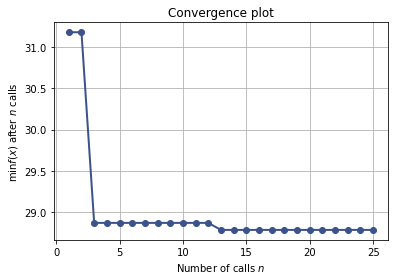

In [32]:
plot_convergence(result)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

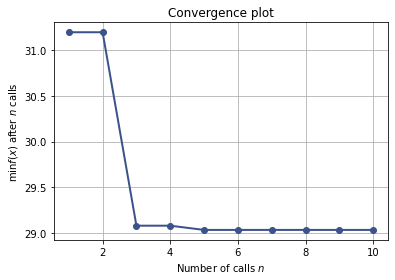

In [52]:
plot_convergence(result)

In [ ]:
# See documentation for all XGBoost parameters
# https://xgboost.readthedocs.io/en/stable/parameter.html

# typical values from
# https://machinelearningmastery.com/xgboost-for-regression/


parameters = dict(
    # General parameters
    booster = 'gbtree',  # default gbtree
    # Tree Booster Parameters
    eta = 0.3,  # learning_rate default 0.3 range [0, 1]
    max_depth = 6,  # default 6 typical 1–10
    colsample_bytree = 0.3,  # default 1 range (0, 1]
    reg_lambda = 1,  # L2 regularization default 1
    alpha = 0,  # L1 regularization default 0
    # Learning Task Parameters
    objective = 'reg:squarederror',  # default reg:squarederror
    eval_metric = 'rmse',  # regression default 'rmse'
    seed = rs  # random seed
)


In [20]:
# SKlearn wrapper
xg_reg = xgb.XGBRegressor(
    objective='reg:linear',
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 5,
    alpha = 10,
    n_estimators = 10
)

In [ ]:
xg_reg.fit(X_train, y_train)

## Predicting 

In [ ]:
y_pred = xg_reg.predict(X_test)

## Model Evaluation

In [ ]:
# Root mean squared error
rmse = np.sqrt(mean_squared_error(y_true=y_test,
                                  y_pred=y_pred))
print(f'RMSE: {rmse}')

## Cross validation

In [28]:
params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10}

cv_results = xgb.cv(
    dtrain=DMat_train,
    params=params,
    nfold=10,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="rmse",
    as_pandas=True,
    seed=rs
)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,49.028738,1.384329,48.131224,11.066208
1,48.566323,1.242813,48.097417,11.097063
2,48.057483,1.231910,48.080196,11.088847
3,47.719241,1.140849,48.058368,11.078099
4,47.380982,1.088023,48.047839,11.073436
5,46.999593,1.097431,48.032086,11.059549
6,46.729069,1.100107,48.045394,11.059372
7,46.375066,1.065767,48.035052,11.064200
8,46.038830,1.095449,48.012355,11.056813
9,45.799416,1.093588,48.027459,11.047552


## Visualize

In [29]:
xg_reg = xgb.train(
    params=params,
    dtrain=DMat_train,
    num_boost_round=10
)

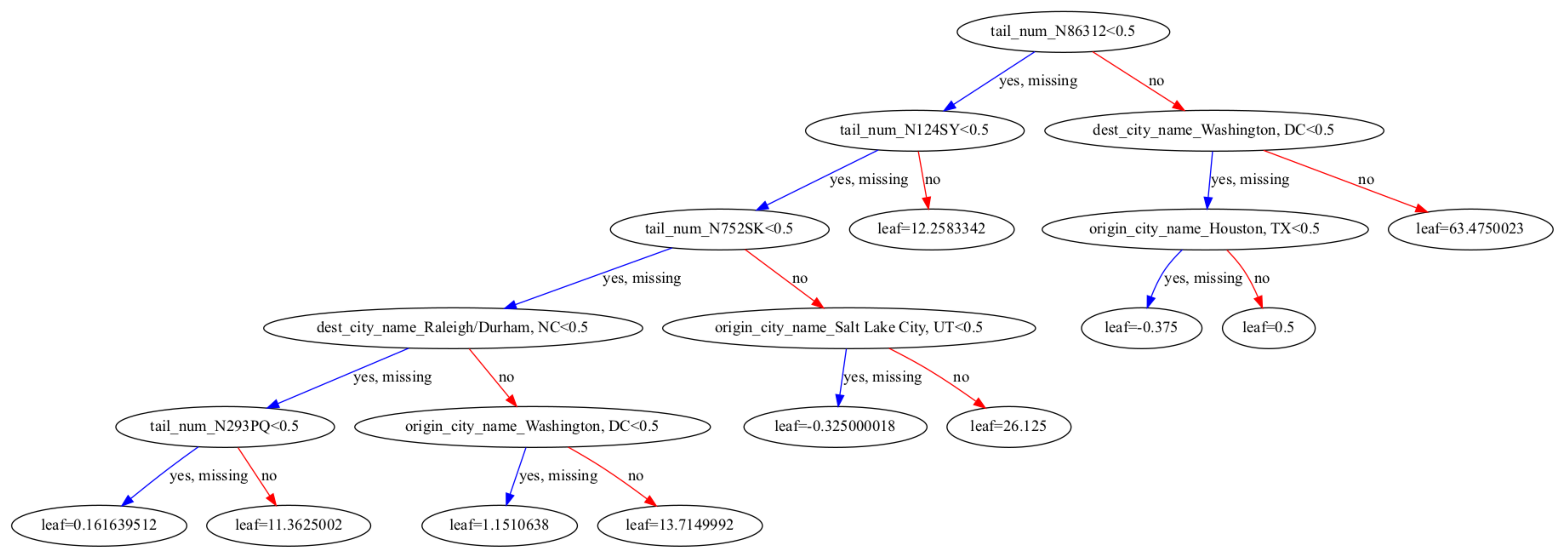

In [38]:
ax = xgb.plot_tree(booster=xg_reg, num_trees=0)
fig = ax.figure
fig.set_size_inches(50, 10)

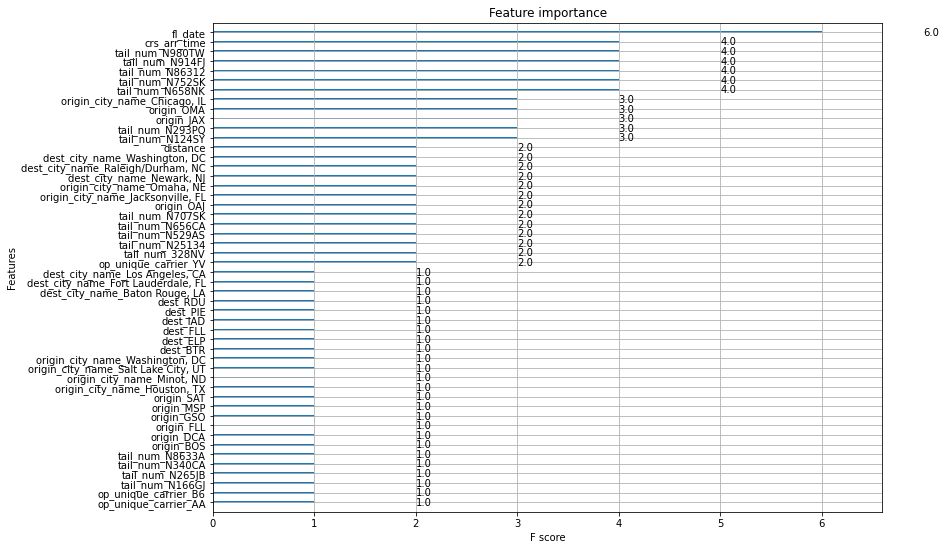

In [36]:
# Feature Importance
ax = xgb.plot_importance(xg_reg)
fig = ax.figure
fig.set_size_inches(12, 9)